# Enzymath
## Estimación de los parámetros cinéticos de Michaelis-Menten de datos experimentales 👩🏻‍🔬🔬📊

<!-- LTeX: language=es -->
### 0. Objetivos

En este notebook aprenderemos cómo estimar los parámetros cinéticos (de Michaelis-Menten) de una enzima a partir de datos experimentales.
Este proceso no es diferente de cómo estimaríamos parámetros de otros modelos matemáticos así que si aprender esta metodología te será útil más allá de la cinética enzimática.

Primero importemos los paquetes de `Julia` que usaremos: [`LsqFit`](https://julianlsolvers.github.io/LsqFit.jl/latest/) para hacer una regresión lineal / no lineal, y `Plots` para graficar.
Usaremos `LsqFit` ([método de mínimos cuadrados](https://es.wikipedia.org/wiki/Mínimos_cuadrados)) para ahorrar tiempo programando una regresión, pero realmente no es complicado programarla nosotrxs mismxs.

In [1]:
# Importar paquetes de Julia
using LsqFit    # Para regresiones lineales y no lineales.
using Plots     # Para graficar.

<!-- LTeX: language=es -->
Este es el plan,

1. Simular datos cinéticos experimentales (con parámetros que nosotros elegiremos).
2. Estimar los parámetros de los datos mediante una regresión lineal (método de Lineweaver-Burk).
3. Estimar los parámetros de los datos mediante una regresión no lineal.
4. Comparar resultados de las dos regresiones.

En particular, usaremos datos simulados para comparar los parámetros reales (definidos por nosotros) con los que obtengamos de las regresiones, y encontrar potenciales problemas.
Usar datos "sintéticos" es muy común en investigación para validar métodos antes de aplicarlos a datos empíricos.

<!-- LTeX: language=es -->
### 1. Simulación de datos experimentales

Recordemos el modelo de cinética enzimática de Michaelis-Menten,
\begin{equation}
V = \frac{V_{max} [S]}{K_m + [S]},
\end{equation}
donde $[S]$ es la concentración de sustrato (la variable independiente), $V$ es la velocidad de generación de producto (la variable dependiente), y $V_{max}$ y $K_m$ son parámetros cinéticos.
Mientras que $V_{max}$ es la velocidad máxima de reacción (si el sustrato fuera infinito), $K_m$ es la concentración de sustrato $[S]$ a la cual la $V$ es exactamente $V_{max}/2$.

In [2]:
# Modelo cinético de Michaelis-Menten
# Se agrupan a V_max y K_m en el vector p solo por conveniencia
function MM(S, p)
    V_max = p[1]
    K_m = p[2]
    return V_max .* S ./ (S .+ K_m)
end

MM (generic function with 1 method)

<!-- LTeX: language=es -->
Ahora definamos las condiciones que simularemos.
Una vez especificados $[S]$, $V_{max}$ y $K_m$, podremos simular $V$ usando el modelo de Michaelis-Menten.

In [3]:
# Establecer cantidades de sustrato para simular curva cinética
S = 50:200:2000;

# Establecer parámetros (reales) para simular datos
V_max = 1;
K_m = 200;
p = [V_max, K_m]; # Agrupemos V_max y K_m en el vector p

In [4]:
# Simular cinética enzimática de Michaelis-Menten
V_exacta = MM(S, p)

10-element Vector{Float64}:
 0.2
 0.5555555555555556
 0.6923076923076923
 0.7647058823529411
 0.8095238095238095
 0.84
 0.8620689655172413
 0.8787878787878788
 0.8918918918918919
 0.9024390243902439

<!-- LTeX: language=es -->
Para hacer nuestros datos simulados (`V_exacta`) más realistas, agreguemos un poco de error de medición experimental y llamémosle `V_medida`.
Aunque no lo parezca, el error de medición es una realidad ubicua que intentamos minimizar, pero que puede interferir con nuestros análisis.

In [5]:
# Agregar error de medición experimental a los datos simulados
# randn muestrea la distribución normal con media 0 y desviación estándar 1
V_medida = V_exacta .+ 0.01 .* randn(length(S))

10-element Vector{Float64}:
 0.20583430768389713
 0.571401880136225
 0.6989415669223216
 0.7761172939914297
 0.8194750746391839
 0.8480332374687649
 0.8678476916510249
 0.8805018416137287
 0.8789141451900705
 0.9006204130429908

<!-- LTeX: language=es -->
Veamos cómo lucen los datos simulados:

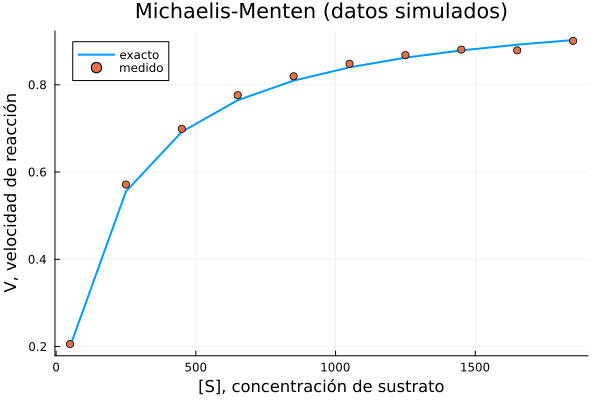

In [6]:
# Graficar datos cinéticos simulados de Michaelis-Menten
plot(S, V_exacta, lw=2, xlabel="[S], concentración de sustrato", ylabel="V, velocidad de reacción", title="Michaelis-Menten (datos simulados)", label="exacto")
scatter!(S, V_medida, lw=2, label="medido")

<!-- LTeX: language=es -->
Ahora que tenemos datos, enfoquémonos en cómo estimar los parámetros $V_{max}$ y $K_m$ de ellos.
Estimar parámetros es también conocido como un problema inverso, y típicamente usamos una [regresión](https://es.wikipedia.org/wiki/Análisis_de_la_regresión) para conseguirlo.

La ecuación de Michaelis-Menten es un modelo no lineal, pues la variable $[S]$ aparece también en el denominador.
Dado que es técnicamente más fácil hacer una regresión lineal, en los 30's, Hans Lineweaver y Dean Burk propusieron cómo abordar el modelo de Michaelis-Menten con una regresión lineal.
Hoy, este método se conoce la [transformación de Lineweaver-Burk](https://en.wikipedia.org/wiki/Lineweaver–Burk_plot).

Brevemente, esta transformación consiste en tomar el recíproco de la ecuación de Michaelis-Menten y simplificar,
\begin{align*}
\frac{1}{V} & = \frac{K_m}{V_{max} [S]} + \frac{[S]}{V_{max} [S]} \\
& = \left( \frac{K_m}{V_{max}} \right) \frac{1}{[S]} + \frac{1}{V_{max}} 
\end{align*}
para obtener la ecuación de una recta,
\begin{equation*}
y = m x + b .
\end{equation*}
Donde las variables son
\begin{align*}
y & = \frac{1}{V}, x  = \frac{1}{[S]} 
\end{align*}
y los parámetros son
\begin{align*}
m & = \frac{K_m}{V_{max}}, b = \frac{1}{V_{max}} .
\end{align*}

Usando esta ecuación de la recta, se puede hacer una regresión lineal de la pendiente ($m$) y ordenada al origen ($b$) que nos permita obtener las constantes cinéticas como
\begin{align*}
V_{max} & = \frac{1}{b}, K_m = \frac{m}{b} .
\end{align*}

Veamos la transformación de Lineweaver-Burk para los datos que simulamos:

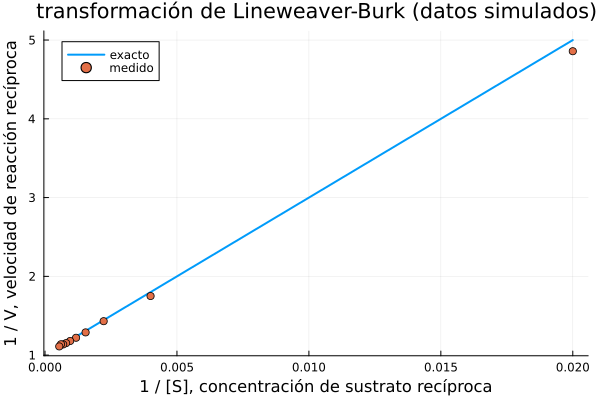

In [7]:
# Transformación de Lineweaver-Burk de los datos simulados
x = 1 ./ S;
y_exacta = 1 ./ V_exacta;
y_medida = 1 ./ V_medida;

# Graficar la transformación (lineal) de Lineweaver-Burk
plot(x, y_exacta, lw=2, xlabel="1 / [S], concentración de sustrato recíproca", ylabel="1 / V, velocidad de reacción recíproca", title="transformación de Lineweaver-Burk (datos simulados)", label="exacto")
scatter!(x, y_medida, lw=2, label="medido")

<!-- LTeX: language=es -->
Los datos realmente siguen una recta, pero el error de medición experimental los distorsiona, potencialmente creando problemas.

Ahora veamos cómo evaluar si ciertos parámetros son buenas estimaciones.
Aquí lo haremos midiendo la diferencia entre lo que dicen los datos y lo que dice el modelo.
En concreto, lo que predice el modelo $y^{\text{(modelo)}}$ es una función de la variable independiente ($[S]$) y los parámetros ($V_{max}, K_m$),
\begin{equation}
y^{\text{(modelo)}} = f([S], V_{max}, K_m) .
\end{equation}
Donde $[S]$ está en los datos y $V_{max}$ y $K_m$ es lo que podemos manipular para hacerla coincidir con lo que dicen los datos en $y^{\text{(datos)}}$.

Un modelo siempre es una simplificación de la realidad, por lo que esperamos cierto error por cada punto en los datos $\epsilon_i$.
Poniendo todo junto,
\begin{align*}
y_i^{\text{(datos)}} = y_i^{\text{(modelo)}} + \epsilon_i .
\end{align*}
Donde el subíndice $i$ indica un punto de los datos.

Tomando la ecuación anterior y resolviendo para los llamados "residuos" $\epsilon_i$, encontramos que
\begin{align*}
\epsilon_i = & y_i^{\text{(datos)}} - y_i^{\text{(modelo)}} .
\end{align*}

Nuestro objetivo en una regresión es minimizar la [Suma de Residuos al Cuadrado (SRC)](https://es.wikipedia.org/wiki/Suma_residual_de_cuadrados), para acercar las predicciones del modelo a lo observado en los datos,
\begin{align*}
\text{minimizar } \sum_i \epsilon_i^2 .
\end{align*}

Definamos una función que calcule la SRC de nuestros datos:

In [8]:
# Suma de Residuos Cuadrados entre los datos y el modelo
function suma_residuos_cuadrados(modelo, datos, x, p)
    prediccion = modelo(x, p)
    residuos = datos .- prediccion # residuos: diferencia entre lo que dicen los datos y lo que dice el modelo
    residuos_cuadrados = residuos.^2 # residuos elevados al cuadrado para solo lidiar con números positivos
    suma_residuos_cuadrados = sum(residuos_cuadrados) # suma de todos los residuos cuadrados
    return suma_residuos_cuadrados
end

suma_residuos_cuadrados (generic function with 1 method)

<!-- LTeX: language=es -->
Y generemos una lista de parámetros para comparar la SRC en esos valores:

In [9]:
# Establecer parámetros para probar su suma de Residuos Cuadrados
v_max = 0.7:0.05:1.3;
k_m = 170:5:230;

<!-- LTeX: language=es -->
Con esto estamos listos para calcular la SRC y estimar los parámetros mediante una regresión lineal y no lineal.

<!-- LTeX: language=es -->
### 2. Regresión lineal: método de Lineweaver-Burk

Primero definamos la ecuación de una recta,

In [10]:
# Modelo lineal de Lineweaver-Burk
function modelo_lineal(x, p)
    m = p[1]
    b = p[2]
    return m .* x .+ b
end

modelo_lineal (generic function with 1 method)

y calculemos lo que requiere el método (lineal) de Lineweaver-Burk:

In [11]:
# Seleccionar modelo, x, y para la estimación de parámetros
modelo = modelo_lineal;
x = 1 ./ S;
y = 1 ./ V_medida;

Ahora, con un poco de código calculemos la SRC para las diferentes combinaciones de $V_{max}$ y $K_m$ y grafiquémoslo,

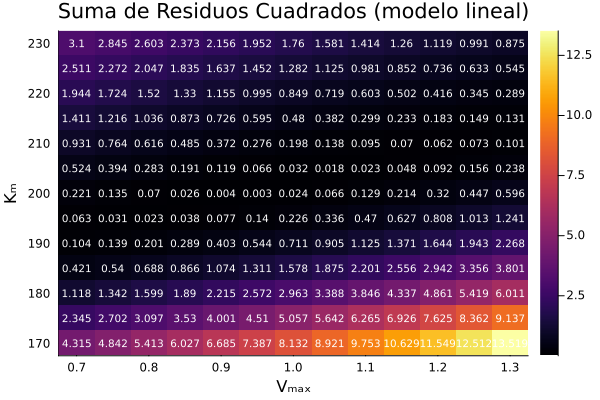

In [12]:
# Evaluar la Suma de Residuos Cuadrados para cada combinación de los parámetros
SRC = [suma_residuos_cuadrados(modelo, y, x, [K_m / V_max, 1 / V_max]) for V_max in v_max, K_m in k_m]

# Graficar heatmap
P = heatmap(v_max, k_m, SRC, xlabel="Vₘₐₓ", ylabel="Kₘ", title="Suma de Residuos Cuadrados (modelo lineal)");
# Mostrar Suma de Residuos Cuadrados en cada celda
nrow, ncol = size(SRC);
ann = [(v_max[j], k_m[i], text(round(SRC[i, j], digits=3), 7, :white, :center)) for i in 1:nrow for j in 1:ncol];
annotate!(ann)

<!-- LTeX: language=es -->
Podemos ver que cada combinación tiene una SRC diferente, y algunas combinaciones son mejores que otras.
Un método de regresión (lineal o no lineal) busca navegar este espacio de combinaciones para encontrar un punto donde la SRC sea pequeña, idealmente la más pequeña.

Teniendo esto en mente, el siguiente código realiza una regresión del modelo lineal de Lineweaver-Burk y regresa la pendiente $m$ y ordenada al origen $b$, las cuales usamos finalmente para calcular $V_{max}$ y $K_m$,

In [13]:
# Valores iniciales de los parámetros (m = Kₘ / Vₘₐₓ, b = 1 / Vₘₐₓ) para la regresión
p0 = [170. / 0.7, 1. / 0.7];

# Estimar parámetros minimizando la Suma de Residuos Cuadrados
fit_l = curve_fit(modelo, x, y, p0);

# Transformar los parametros estimados m y b a los parámetros cinéticos Vₘₐₓ y Kₘ
pₗ = [1. / fit_l.param[2], fit_l.param[1] / fit_l.param[2]]

2-element Vector{Float64}:
   1.0006147712875564
 192.8670613788232

<!-- LTeX: language=es -->
Veamos cómo se ve el modelo de Michaelis-Menten con estas $V_{max}$ y $K_m$ en relación a los datos, 

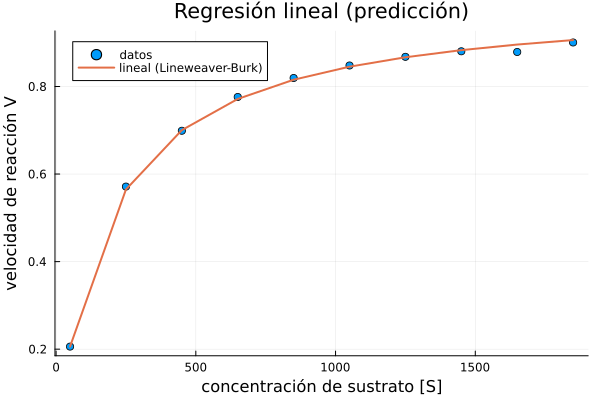

In [14]:
# Evaluar el modelo con los parámetros obtenidos de la regresión lineal (Lineweaver-Burk)
Vₗ = MM(S, pₗ);

# Graficar el modelo con los parámetros obtenidos
scatter(S, V_medida, lw=2, label="datos", xlabel="concentración de sustrato [S]", ylabel="velocidad de reacción V", title="Regresión lineal (predicción)")
plot!(S, Vₗ, lw=2, label="lineal (Lineweaver-Burk)")

### 3. Regresión no lineal

<!-- LTeX: language=es -->
Repitamos lo anterior pero de una regresión directamente del modelo de Michaelis-Menten (no lineal).
Para ello especifiquemos,

In [15]:
# Seleccionar modelo, x, y para la estimación de parámetros
modelo = MM;
x = S;
y = V_medida;

La SRC de las diferentes combinaciones de $V_{max}$ y $K_m$ es,

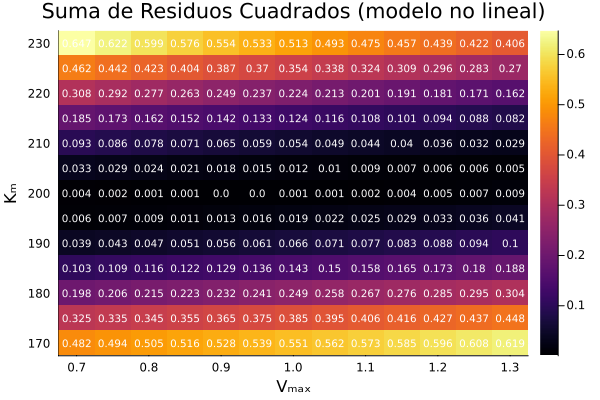

In [16]:
# Evaluar la Suma de Residuos Cuadrados para cada combinación de los parámetros
SRC = [suma_residuos_cuadrados(modelo, y, x, [V_max, K_m]) for V_max in v_max, K_m in k_m]

# Graficar heatmap
P = heatmap(v_max, k_m, SRC, xlabel="Vₘₐₓ", ylabel="Kₘ", title="Suma de Residuos Cuadrados (modelo no lineal)");
# Mostrar Suma de Residuos Cuadrados en cada celda
nrow, ncol = size(SRC);
ann = [(v_max[j], k_m[i], text(round(SRC[i, j], digits=3), 7, :white, :center)) for i in 1:nrow for j in 1:ncol];
annotate!(ann)

Nuevamente algunas combinaciones son mejores que otras.
Y al realizar la regresión no lineal podemos obtener directamente $V_{max}$ y $K_m$,

In [17]:
# Valores iniciales de los parámetros (Vₘₐₓ, Kₘ) para la regresión
p0 = [0.7, 170.];

# Estimar parámetros minimizando la Suma de Residuos Cuadrados
fit_nl = curve_fit(modelo, x, y, p0);

# Extraer los parámetros cinéticos estimados Vₘₐₓ y Kₘ
pₙₗ = [fit_nl.param[1], fit_nl.param[2]]

2-element Vector{Float64}:
   0.9918106820287748
 185.0210781183917

<!-- LTeX: language=es -->
Veamos cómo se ve el modelo de Michaelis-Menten con estas $V_{max}$ y $K_m$ en relación a los datos, 

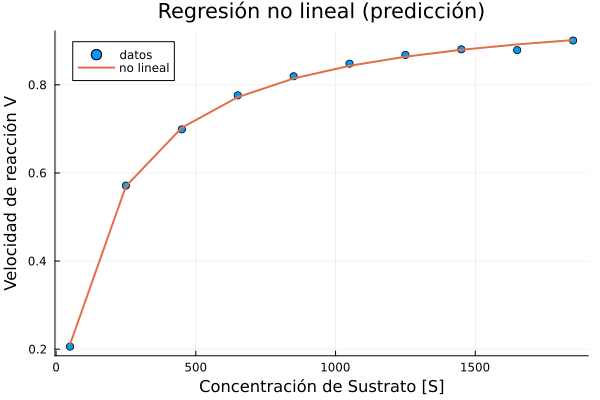

In [18]:
# Evaluar el modelo con los parámetros obtenidos de la regresión no lineal
Vₙₗ = MM(S, pₙₗ);

# Graficar el modelo con los parámetros obtenidos
scatter(S, V_medida, lw=2, label="datos", xlabel="Concentración de Sustrato [S]", ylabel="Velocidad de reacción V", title="Regresión no lineal (predicción)")
plot!(S, Vₙₗ, lw=2, label="no lineal")

<!-- LTeX: language=es -->
### 4. Comparación de resultados

Finalmente, veamos una comparación numérica y gráfica de los resultados de las dos regresiones.
¿Cuál fue el método más atinado?

In [19]:
# Imprimir los valores reales y estimados por cada tipo de regresión
println("Parámetros reales:\t", p)
println("Regresión lineal (L-B):\t", pₗ)
println("Regresión no lineal:\t", pₙₗ)

Parámetros reales:	[1, 200]
Regresión lineal (L-B):	[1.0006147712875564, 192.8670613788232]
Regresión no lineal:	[0.9918106820287748, 185.0210781183917]


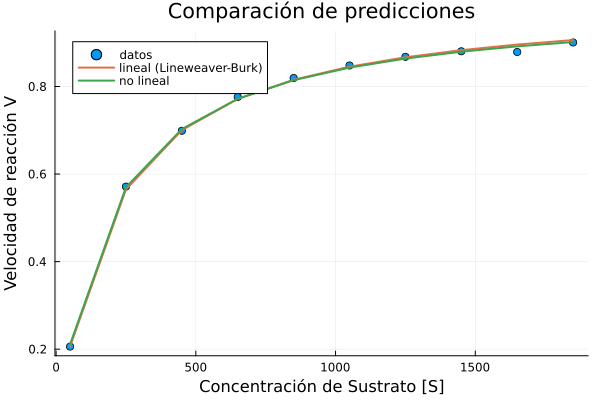

In [20]:
# Graficar datos simulados y la predicción en base a la regresión lineal y no lineal de parámetros
scatter(S, y, lw=2, label="datos", xlabel="Concentración de Sustrato [S]", ylabel="Velocidad de reacción V", title="Comparación de predicciones")
plot!(S, Vₗ, lw=2, label="lineal (Lineweaver-Burk)")
plot!(S, Vₙₗ, lw=2, label="no lineal")

<!-- LTeX: language=es -->
### Para practicar - 🏠📚.

1. Corre el notebook varias veces para simular datos con distinto ruido experimental y ve su efecto.
2. Aumenta el ruido experimental (cambia `0.01` por un número más grande en `V_medida = V_exacta .+ 0.01 .* randn(length(S))`).
¿Cuál el efecto en la estimación de parámetros y predicción de la cinética?
3. Reduce la cantidad de sustrato mínima en la cinética (cambia `50` por un número más pequeño en `S = 50:200:2000;`).
¿Cuál es el efecto en la estimación de parámetros y predicción de la cinética?
¿Siguen siendo confiables los resultados de la regresión lineal (Lineweaver-Burk) y no lineal en este contexto?
4. Prueba diferentes valores de $V_{max}$ y $K_m$ en los datos simulados y ve que estimaciones arrojan las regresiones.